In [130]:
import os
import cv2
import numpy as np

In [131]:
path = os.path.abspath('../data')
path

'/home/roger/code/xkeeja/corpy-assessment/data'

In [150]:
def load_data(path):    
    g_files = []
    ng_files = []
    X, y = [], []
    scale = 0.25

    g_dir = os.path.join(path,'train','good')
    for f in os.listdir(g_dir):
        g_files.append(f)

    for file in g_files:
        img = cv2.imread(os.path.join(g_dir, file))
        width = int(img.shape[1] * scale)
        height = int(img.shape[0] * scale)
        resized = cv2.resize(img, (width, height), interpolation=cv2.INTER_AREA)
        X.append(resized)
        y.append(0)
        
    ng_dir = os.path.join(path,'train','not-good')
    for f in os.listdir(ng_dir):
        ng_files.append(f)

    ng_key = {
        'manipulated_front':1,
        'scratch_head':2,
        'scratch_neck':3,
        'thread_side':4,
        'thread_top':5
    }

    for file in ng_files:
        img = cv2.imread(os.path.join(ng_dir, file))
        width = int(img.shape[1] * scale)
        height = int(img.shape[0] * scale)
        resized = cv2.resize(img, (width, height), interpolation=cv2.INTER_AREA)
        X.append(resized)
        ng_ref = file.rstrip('.png').rstrip('1234567890')
        y.append(ng_key[ng_ref])

    c = list(zip(X, y))
    np.random.shuffle(c)
    X, y = zip(*c)
    
    X = np.array(X)/255.
    y = np.array(y)
    
    return X, y

In [151]:
X, y = load_data(path)
X.shape, y.shape

((300, 256, 256, 3), (300,))

In [135]:
# cv2.imshow('sample',X[38])
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [136]:
np.unique(X)

array([0.08235294, 0.09019608, 0.09803922, 0.10196078, 0.10588235,
       0.10980392, 0.11372549, 0.11764706, 0.12156863, 0.1254902 ,
       0.12941176, 0.13333333, 0.1372549 , 0.14117647, 0.14509804,
       0.14901961, 0.15294118, 0.15686275, 0.16078431, 0.16470588,
       0.16862745, 0.17254902, 0.17647059, 0.18039216, 0.18431373,
       0.18823529, 0.19215686, 0.19607843, 0.2       , 0.20392157,
       0.20784314, 0.21176471, 0.21568627, 0.21960784, 0.22352941,
       0.22745098, 0.23137255, 0.23529412, 0.23921569, 0.24313725,
       0.24705882, 0.25098039, 0.25490196, 0.25882353, 0.2627451 ,
       0.26666667, 0.27058824, 0.2745098 , 0.27843137, 0.28235294,
       0.28627451, 0.29019608, 0.29411765, 0.29803922, 0.30196078,
       0.30588235, 0.30980392, 0.31372549, 0.31764706, 0.32156863,
       0.3254902 , 0.32941176, 0.33333333, 0.3372549 , 0.34117647,
       0.34509804, 0.34901961, 0.35294118, 0.35686275, 0.36078431,
       0.36470588, 0.36862745, 0.37254902, 0.37647059, 0.38039

In [137]:
from tensorflow.keras import Sequential, layers

In [175]:
def initialize_model():
    model = Sequential()
    
    model.add(layers.Conv2D(16, (3,3), input_shape=(256, 256, 3), padding='same', activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(32, (3,3), activation='relu'))
    # model.add(layers.Dropout(0.2))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    # model.add(layers.Dropout(0.3))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    # model.add(layers.Conv2D(64, (3,3), activation='relu'))
    # model.add(layers.Dropout(0.3))
    # model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(20, activation='relu'))
    # model.add(layers.Dropout(0.4))
    model.add(layers.Dense(6, activation='softmax'))
    
    return model

In [177]:
from tensorflow.keras import optimizers

opt = optimizers.Adam(learning_rate=0.00001)

def compile_model(model):
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [178]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience=10, restore_best_weights=True, verbose=1)

In [179]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.2, 1: 5.0, 2: 5.0, 3: 5.0, 4: 5.0, 5: 5.0}

In [180]:
from tensorflow.keras.utils import to_categorical
y_cat = to_categorical(y, 6)

In [181]:
model = initialize_model()
compile_model(model)
history = model.fit(X, y_cat, epochs=100, batch_size=32, validation_split=0.3, callbacks=[es], class_weight=class_weights, verbose=1)

Epoch 1/100
7/7 [==============================] - 5s 610ms/step - loss: 1.7841 - accuracy: 0.0238 - val_loss: 1.8907 - val_accuracy: 0.0111
Epoch 2/100
7/7 [==============================] - 4s 605ms/step - loss: 1.7635 - accuracy: 0.0429 - val_loss: 1.8463 - val_accuracy: 0.0111
Epoch 3/100
7/7 [==============================] - 4s 583ms/step - loss: 1.7529 - accuracy: 0.0429 - val_loss: 1.8270 - val_accuracy: 0.0111
Epoch 4/100
7/7 [==============================] - 4s 582ms/step - loss: 1.7476 - accuracy: 0.0476 - val_loss: 1.7969 - val_accuracy: 0.0111
Epoch 5/100
7/7 [==============================] - 4s 593ms/step - loss: 1.7467 - accuracy: 0.0524 - val_loss: 1.8314 - val_accuracy: 0.0111
Epoch 6/100
7/7 [==============================] - 4s 616ms/step - loss: 1.7492 - accuracy: 0.0429 - val_loss: 1.8458 - val_accuracy: 0.0111
Epoch 7/100
7/7 [==============================] - 4s 577ms/step - loss: 1.7459 - accuracy: 0.0429 - val_loss: 1.8469 - val_accuracy: 0.0111
Epoch 8/100
7

KeyboardInterrupt: 

In [172]:
import matplotlib.pyplot as plt

def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

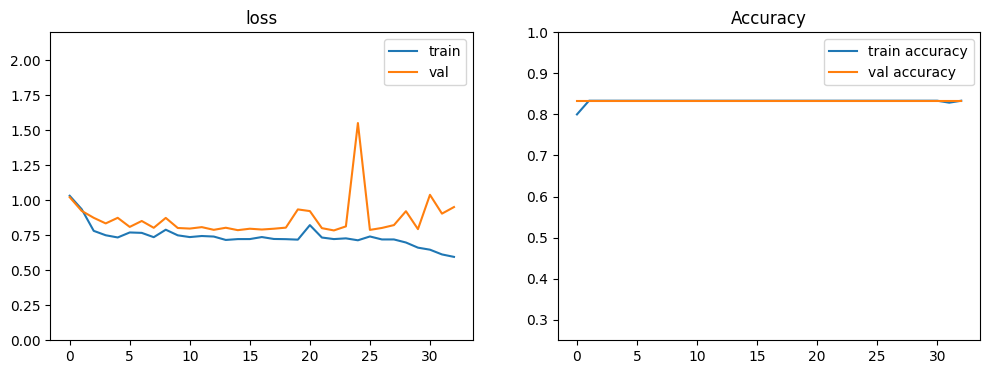

In [173]:
plot_history(history);